# Module 1 Integrated Project

## Project Description

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. 

You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

## Step 1: Open the data file and study the general information

Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy as sp
from datetime import datetime
from datetime import timedelta
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

Load the data and investigate it

In [2]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Checking percentage of missing values

In [4]:
games.isnull().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

## Conclusions for Step 1
- There are 16715 rows, describing the info for each video game that the online store Ice sells.
- The variables (attributes) of the video games include name, platform, year that the game was released, genre, sale value in USD million in North America - Europe - Japan and other countries, expert review presented via critic score, user review presented via user score and ESRB rating categories (suggesting age appropriateness for each game).
- The following variables having missing values (in descending order of the number of missing values):
    - Critic_Score: 51.3%
    - Rating: 40.4%
    - User_Score: 40.1%
    - Year_of_Release: 1.6%
    - Genre & Name: < 0.01%
- Some preliminary data preprocessing tasks need to do:
    - Change name of column to lower case
    - Change data types: User_Score (object to float), optional: Year_of_Release (float to int)

## Step 2: Prepare the data

### Task description:
- Replace the column names (make the lowercase)
- Convert data to the required types
- Deal with missing values
- Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column

### 2.1 Replace the column names (change to lowercase)

In [5]:
games.columns = games.columns.str.lower()

In [6]:
games.columns #successfully change names to lowercase

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.2 Convert data to the required types

2.2.1 user_score: change to float type
Implement the try-except function to avoid the string "tbd" in this column, and also to replace "tbd" by NaN - because these are real missing values, i.e. the review score from the users is not determined yet.

In [7]:
try: 
    games['user_score'] = games['user_score'].astype(float)
except: 
    games['user_score'] = games['user_score'].replace('tbd', np.NaN)

In [8]:
games['user_score'].isnull().mean() #increase from 0.40 to 0.54 due to the adding NaN

0.5459168411606342

In [9]:
games['user_score'] = games['user_score'].astype(float)
games['user_score'].dtypes #done converting

dtype('float64')

2.2.2 year_of_release: change to int type

In [10]:
games['year_of_release'] = games['year_of_release'].astype('Int64')

In [11]:
games['year_of_release'].dtypes #done converting

Int64Dtype()

### 2.3 Deal with missing values

In [12]:
games.isnull().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.545917
rating             0.404786
dtype: float64

Investigate "name" and "genre" columns

In [13]:
games.query('name.isnull() or genre.isnull()', engine='python')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


**Comment**: We can't restore the missing values for these two observations with NaN name or genre because there are no other columns that provide more info to identify which values should be replaced with. In addition, these two observations have missing values in other columns. Finally, 2 observations is a teenie tiny number compared with the whole dataset. Therefore, it's safe to drop these two observations. 

In [14]:
games = games.dropna(subset=['name', 'genre'])

Investigate "year_of_release" column

In [15]:
games.query('year_of_release.isnull()', engine='python').tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.0,0.0,0.0,43.0,NaN,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.0,0.0,0.0,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.0,0.0,0.0,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.0,0.0,0.0,NaN,NaN,NaN
16522,Virtua Quest,GC,<NA>,Role-Playing,0.01,0.0,0.0,0.0,55.0,5.5,T


**Comment**: Some of the names of game have the year of release in them (often that year minus 1 rather than the exact year: check some cases on google), therefore we can extract the year in the "name" column to replace missing values in the "year_of_release" column. Actually we can google all the year of release for each game, but there are total 269 rows that miss "year_of_release" values. Therefore it is not practical to manually fill in missing values if the name of game doesn't indicate it. In conclusion, I'll first impute missing values by the year that can be extracted from the "name" column, the remaining missing values will be left intact. 

Extract number (year) in the "name" column using regrex

In [16]:
games['year_extract_from_name'] = games.name.str.extract(r'(?!\()\b(\d{4})') 

games['year_extract_from_name'].unique()

array([nan, '2015', '2004', '2100', '2005', '2007', '2003', '2012',
       '2008', '2014', '2002', '2006', '2009', '2013', '2011', '2010',
       '2000', '1080', '2001', '1886', '2016', '2070', '2600', '1500',
       '1942', '1999', '2033', '1000', '2017', '2048', '2025', '0122',
       '1001', '1701', '2205', '0081', '2020', '2049', '1692', '1945',
       '0079', '1969', '1996', '1800', '2089', '1946', '2500', '1450',
       '2142', '1943', '3000'], dtype=object)

Convert "year_extract_from_name" to int type

In [17]:
games['year_extract_from_name'] = games['year_extract_from_name'].astype('float') # first convert to float before int
 
games['year_extract_from_name'] = games['year_extract_from_name'].astype('Int64')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    16713 non-null  object 
 1   platform                16713 non-null  object 
 2   year_of_release         16444 non-null  Int64  
 3   genre                   16713 non-null  object 
 4   na_sales                16713 non-null  float64
 5   eu_sales                16713 non-null  float64
 6   jp_sales                16713 non-null  float64
 7   other_sales             16713 non-null  float64
 8   critic_score            8137 non-null   float64
 9   user_score              7590 non-null   float64
 10  rating                  9949 non-null   object 
 11  year_extract_from_name  898 non-null    Int64  
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


Remove impractical year (noise from the 'name' column: a number, not a year)
- Inspect the range of the practical year (refer to the range in the "year_of_release")
- Remove the impractical year

In [18]:
#Inspect the range of the practical year
games['year_of_release'].value_counts() #1980 - 2016

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: Int64

In [19]:
games['year_extract_from_name'].unique()

<IntegerArray>
[<NA>, 2015, 2004, 2100, 2005, 2007, 2003, 2012, 2008, 2014, 2002, 2006, 2009,
 2013, 2011, 2010, 2000, 1080, 2001, 1886, 2016, 2070, 2600, 1500, 1942, 1999,
 2033, 1000, 2017, 2048, 2025,  122, 1001, 1701, 2205,   81, 2020, 2049, 1692,
 1945,   79, 1969, 1996, 1800, 2089, 1946, 2500, 1450, 2142, 1943, 3000]
Length: 51, dtype: Int64

Remove impractical year from the 'year_extract_from_name' column

In [20]:
games['year_extract_from_name'] = games['year_extract_from_name']\
    .where((games['year_extract_from_name'] >= 1981) \
           & (games['year_extract_from_name'] <= 2017), np.nan)


games['year_extract_from_name'].unique()

<IntegerArray>
[<NA>, 2015, 2004, 2005, 2007, 2003, 2012, 2008, 2014, 2002, 2006, 2009, 2013,
 2011, 2010, 2000, 2001, 2016, 1999, 2017, 1996]
Length: 21, dtype: Int64

In [21]:
games.query('year_of_release.isnull() \
            and year_extract_from_name.notna()', engine='python')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_extract_from_name
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,2004
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,2004
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,2006
1650,NASCAR Thunder 2003,PS2,<NA>,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E,2003
2572,PES 2009: Pro Evolution Soccer,PSP,<NA>,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN,2009
3486,Madden NFL 2002,XB,<NA>,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E,2002
4775,NFL GameDay 2003,PS2,<NA>,Sports,0.20,0.15,0.00,0.05,60.0,NaN,E,2003
5156,NBA Live 2003,XB,<NA>,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E,2003
5336,Tomb Raider (2013),PC,<NA>,Action,0.06,0.25,0.00,0.04,86.0,8.5,M,2013
5655,All-Star Baseball 2005,PS2,<NA>,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E,2005


In [22]:
games['year_of_release'] = games['year_of_release']\
    .fillna(games['year_extract_from_name']-1)


games.query('year_of_release.isnull() \
    and year_extract_from_name.notna()', engine='python') #Done

games['year_of_release'].unique()


<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, 1995, 1991, 1981, 1987, 1980, 1983, <NA>]
Length: 38, dtype: Int64

Investigate "critic_score", "user_score" and "rating" columns

In [138]:
games.query('critic_score.isnull() \
    or user_score.isnull() or rating.isnull()', engine='python').tail(30)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_extract_from_name,total_sale
16682,Grisaia no Kajitsu: La Fruit de la Grisaia,PSP,2013,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16683,Scarlett: Nichijou no Kyoukaisen,PS2,2008,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16684,7'scarlet,PSV,2016,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16685,Help Wanted: 50 Wacky Jobs (jp sales),Wii,2008,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16686,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008,Racing,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16687,Neo Angelique Special,PSP,2008,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16688,Outdoors Unleashed: Africa 3D,3DS,2011,Sports,0.01,0.00,0.00,0.0,NaN,NaN,T,<NA>,0.01
16689,Real Rode,PS2,2008,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01
16690,Pony Friends 2,PC,2009,Simulation,0.00,0.01,0.00,0.0,NaN,NaN,NaN,<NA>,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN,<NA>,0.01


**Comment**: Since there are up to 40% - more than 50% missing values (too many) in these three columns, and there is no exact way to restore the missing values, also there is no need to run machine learning models that require non-NA values, I decide to leave the missing values as they are to avoid bias when conducting exploratory data analysis. Will decide if there is a need to remove these missing values later if the hypothesis testing requires.

### Check duplicated rows

In [24]:
games[games.duplicated(keep = False)] 
#no complete duplicates (rows that have same values on every column)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_extract_from_name


### 2.4 Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column

In [25]:
#Create a list of columns that contain sale info
col_list= ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

#Create a new column that is the sum of sales from all regions
games['total_sale'] = games[col_list].sum(axis=1)

games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_extract_from_name,total_sale
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,<NA>,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,<NA>,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,<NA>,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,<NA>,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,<NA>,31.38


## Conclusions for Step 2:
- Replace the column names (make the lowercase): Done
- Convert data to the required types: Done
- Deal with missing values: Done
- Calculate the total sales (the sum of sales in all regions) for each game: Done

## Step 3: Analyze data

### Task description:
-	Look at how many games were released in different years. Is the data for every period significant?
-	Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?
-	Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017. Work only with the data that you've decided is relevant. Disregard the data for previous years.
-	Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.
-	Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.
-	Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.
-	Keeping your conclusions in mind, compare the sales of the same games on other platforms.
-	Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

### 3.1 How many games were released in different years

**Question**: Is the data for every period significant?

Create a new dataframe by groupby "year_of_release", describe the figures in table

In [26]:
games_by_year = games.groupby('year_of_release')['name']\
    .agg('count').reset_index()

games_by_year.columns = ['year_of_release', 'total_games_released']
games_by_year
#the observations that have missing value in the "year_of_release" do not count in

,year_of_release,total_games_released
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


Describe the figures in plot - create the function to create the line plot (to apply for other data)

In [27]:
def createlineplot(x, y, hue, hue_order, style, data, 
                   title, xlabel, ylabel):
    plt.figure(figsize=(12,7))
    sns.lineplot(x=x, y=y, hue=hue, hue_order=hue_order, 
                 style=style, data=data, markers=True)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)    

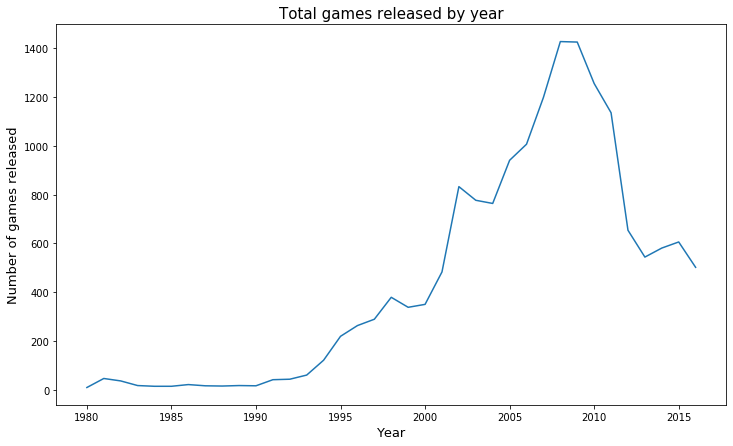

In [28]:
createlineplot('year_of_release', 'total_games_released', 
               None, None, None, games_by_year, 
               'Total games released by year', 'Year', 
               'Number of games released')

**Question**: Is the data for every period significant? <br>
**Answer**: Not every period is significant in terms of the number of games released. There is a dramatic increase in the number of video games released in early 2000 till 2011, after that there is a significant drop. 2008-2009 is the peak period with the highest number of video games released, 1428-1426 games respectively. Before 1994, there are less than 100 games released each year. After 2011, less than 700 games were released each year. 

### 3.2 Look at how sales varied from platform to platform

Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

Look at unique platforms

In [29]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Create a new dataframe for total sales by platform

In [30]:
platform = games.groupby('platform')['total_sale']\
    .agg('sum').reset_index()

platform.sort_values(by= 'total_sale', ascending = False)

,platform,total_sale
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


PS2, X360, PS3, Wii, DS and PS are platforms that have the greatest total sale values, larger than 700 million USD. We'll look deeper into the total sale of these platforms by year.       

Extract the list of names of the greatest sale-value platforms

In [31]:
greatest_platform = platform[platform.total_sale > 
                             platform.total_sale.quantile(.80)]\
    .sort_values(by='total_sale', ascending=False)['platform']
greatest_platform

16     PS2
28    X360
17     PS3
26     Wii
4       DS
15      PS
Name: platform, dtype: object

In [32]:
platform_sale_year = games.query('platform in @greatest_platform', engine='python')\
    .groupby(['platform','year_of_release'])['total_sale'].agg('sum')\
    .reset_index().sort_values(by=(['platform','total_sale']), ascending=False)

platform_sale_year.head()

,platform,year_of_release,total_sale
60,X360,2010,170.08
61,X360,2011,143.84
58,X360,2008,135.26
59,X360,2009,120.29
62,X360,2012,99.74


Create plot

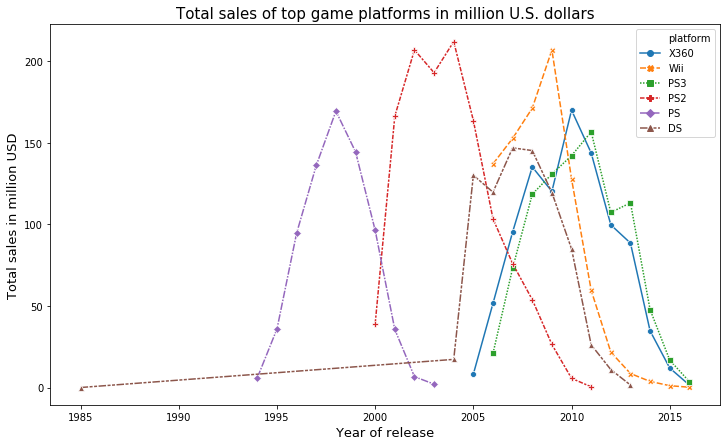

In [33]:
createlineplot('year_of_release', 'total_sale', 'platform', 
               None, 'platform', platform_sale_year, 
               'Total sales of top game platforms in million U.S. dollars', 
               'Year of release', 'Total sales in million USD')



**Question**: How long does it generally take for new platforms to appear and old ones to fade? <br>
**Answer**: The graph shows that it generally takes around 4-6 years for a new platforms to appear, i.e. reach its peak in sale, and it takes around 5-7 years for an old platform to fade, i.e. reach its lowest in sale (approximately zero sales). PS, PS2 and DS seem to stop making profit before 2013, a quick googling confirms this observation, these platforms fade away before 2013. 

### 3.3 Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.

Quick look at total sale and total games released by year (not stratified by platform)

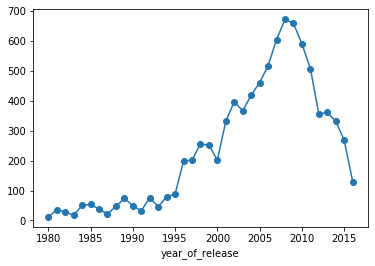

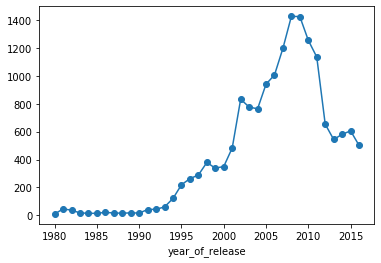

In [34]:
sale_by_year = games.groupby('year_of_release')['total_sale']\
    .sum().plot(style="o-")
games_by_year.plot(x= 'year_of_release', y= 'total_games_released', 
                   style="o-", legend=None)

The 2 graphs of total sale and number of games release have similar shape: There is a dramatic increase in early 2000, especially a constant increase from 2005, till 2011, after that there is a significant drop. The graph "*Total sales of top game platforms in million U.S. dollars*" in the previous section also confirms around 2005, there is a new cycle of platforms arising and fading. 

Therefore, I decide to take data from 2005 onwards (to 2016) because this period is highly likely to depict a new cycle of appearing and fading of game platforms. Thus, we can base on this period to make prognosis for 2017. 

Extract game data from 2005 onwards (need to drop NA values in year_of_release first to query data)

In [35]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    16713 non-null  object 
 1   platform                16713 non-null  object 
 2   year_of_release         16461 non-null  Int64  
 3   genre                   16713 non-null  object 
 4   na_sales                16713 non-null  float64
 5   eu_sales                16713 non-null  float64
 6   jp_sales                16713 non-null  float64
 7   other_sales             16713 non-null  float64
 8   critic_score            8137 non-null   float64
 9   user_score              7590 non-null   float64
 10  rating                  9949 non-null   object 
 11  year_extract_from_name  848 non-null    Int64  
 12  total_sale              16713 non-null  float64
dtypes: Int64(2), float64(7), object(4)
memory usage: 1.8+ MB


In [36]:
games_2005_2016 = games.dropna(subset=['year_of_release'])\
    .query('year_of_release >= 2005', engine='python')


games_2005_2016.info() #11280 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11280 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11280 non-null  object 
 1   platform                11280 non-null  object 
 2   year_of_release         11280 non-null  Int64  
 3   genre                   11280 non-null  object 
 4   na_sales                11280 non-null  float64
 5   eu_sales                11280 non-null  float64
 6   jp_sales                11280 non-null  float64
 7   other_sales             11280 non-null  float64
 8   critic_score            5648 non-null   float64
 9   user_score              5540 non-null   float64
 10  rating                  7312 non-null   object 
 11  year_extract_from_name  492 non-null    Int64  
 12  total_sale              11280 non-null  float64
dtypes: Int64(2), float64(7), object(4)
memory usage: 1.2+ MB


### 3.4 Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.

Create a new dataframe to group by platform for the data from 2000 onwards

In [37]:
platform_2005_2016 = games_2005_2016.groupby('platform')['total_sale']\
    .agg('sum').reset_index()

platform_2005_2016.sort_values(by= 'total_sale', ascending = False)


,platform,total_sale
13,X360,961.30
7,PS3,931.34
11,Wii,891.18
2,DS,785.50
6,PS2,429.50
8,PS4,314.14
9,PSP,283.28
0,3DS,257.81
5,PC,168.14
15,XOne,159.32


Extract the name of platforms in descending order of total sales

In [38]:
platform_name_ordered = platform_2005_2016.sort_values(
    by= 'total_sale', ascending = False)['platform']

platform_name_ordered

13    X360
7      PS3
11     Wii
2       DS
6      PS2
8      PS4
9      PSP
0      3DS
5       PC
15    XOne
12    WiiU
14      XB
10     PSV
3      GBA
4       GC
1       DC
Name: platform, dtype: object

In [39]:
platform_sale_year_20052016 = games_2005_2016.groupby(['platform','year_of_release'])['total_sale']\
    .agg('sum').reset_index()\
    .sort_values(by=(['platform','total_sale']), ascending=False)

platform_sale_year_20052016.head()

,platform,year_of_release,total_sale
108,XOne,2015,60.14
107,XOne,2014,54.07
109,XOne,2016,26.15
106,XOne,2013,18.96
102,XB,2005,49.08


Create plot

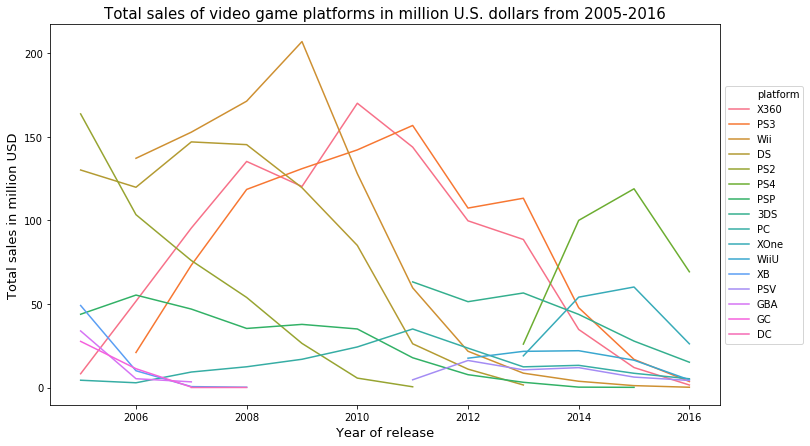

In [40]:
createlineplot('year_of_release', 'total_sale', 'platform', platform_name_ordered, 
                None, platform_sale_year_20052016, 
               'Total sales of video game platforms in million U.S. dollars from 2005-2016', 
               'Year of release', 'Total sales in million USD')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Have a look at the lower-tier (low profit) platforms to see the trend

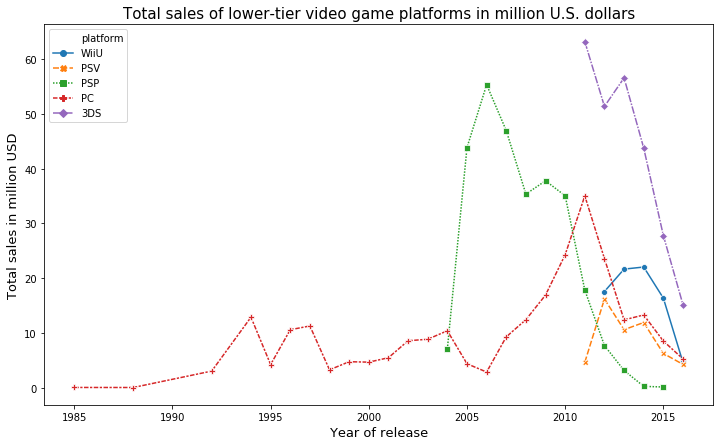

In [41]:
low_tier_pf = ('3DS', 'WiiU', 'PC', 'PSV', 'PSP')
low_tier = games.query('platform in @low_tier_pf', engine='python')
low_tier_grouped = low_tier.groupby(['platform','year_of_release']).agg('sum')\
    .reset_index().sort_values(by=(['platform','total_sale']), ascending=False)



createlineplot('year_of_release', 'total_sale', 'platform', None, 
                'platform', low_tier_grouped, 
               'Total sales of lower-tier video game platforms in million U.S. dollars', 
               'Year of release', 'Total sales in million USD')

**Question**: Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms <br>
**Answer**: 
- In the period from 2005 - 2016, X360, PS3 and Wii are the top 3 platforms leading in sales. 
- In the previous section, we have a conclusion that it generally takes around 4-6 years for a new platforms to appear and it takes around 5-7 years for an old platform to fade. 
    - The following platforms already reached their peak in sale and fade away for 5-7 years: PS2, Wii, DS, X360, PS3, PSP. Thus it is highly likely that these platforms approaching their end (shrinking to zero sale). The other platforms that ended their life earlier (before 2008) are: XB, GBA, GC, and DC. 
    - Though there is a tendency for decreasing, the following platforms have not reached the "appearing" period (4-6 years), so there is a chance for these platforms to rise, or at least last for several more years: PS4, XOne, 3DS, PSV, WiiU.
    - PC is a special case which has a longer life span than the other platforms, so it's hard to predict based on the previous period pattern. 

### 3.5 Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

In [42]:
def createboxplot(x, y, hue, data, title, xlabel, ylabel, top):
    plt.figure(figsize=(15,10))
    sns.boxplot(x=x, y=y, hue=hue, data=data, palette="Set2")
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.ylim(0,top)
    

Create the boxplot with full number of outliers

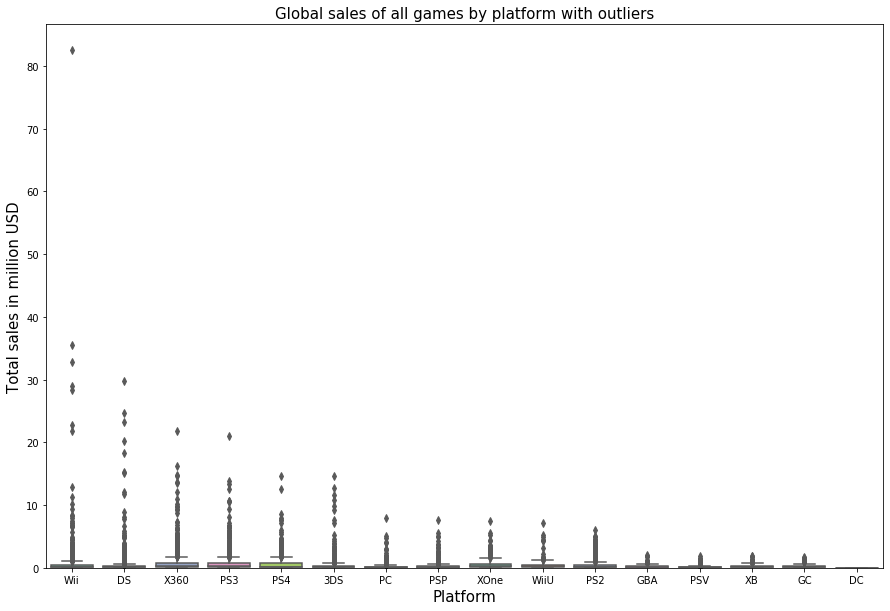

In [43]:
createboxplot('platform', 'total_sale', None, 
              games_2005_2016, 'Global sales of all games by platform with outliers', 
              'Platform', 'Total sales in million USD', top=None)

Create the boxplot with less outliers

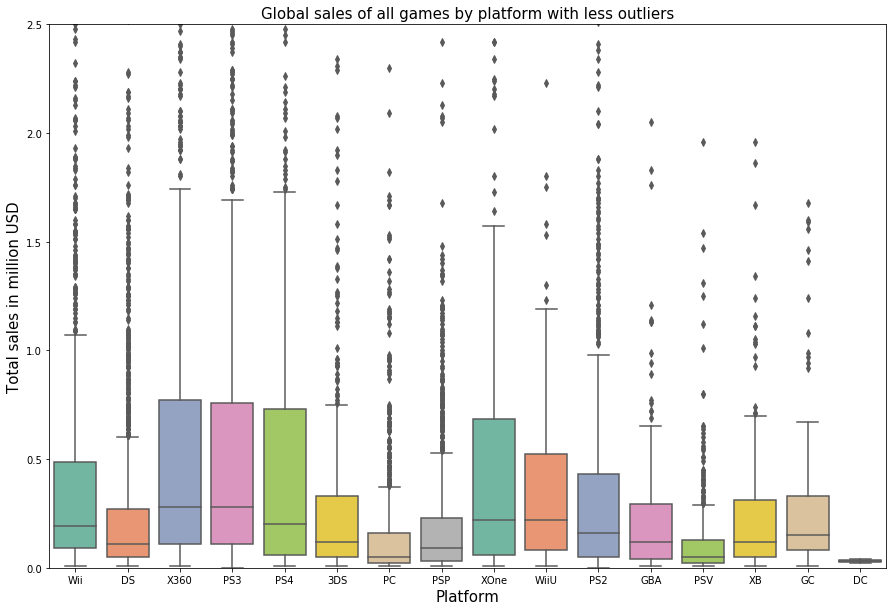

In [44]:
createboxplot('platform', 'total_sale', None, 
              games_2005_2016, 'Global sales of all games by platform with less outliers', 
              'Platform', 'Total sales in million USD', top=2.5)

**Question**: Are the differences in sales significant? What about average sales on various platforms? <br>
**Answer**: 
- There are significant differences in total sales among platforms due to the extreme sale values, for example in PS3, X360, PS4, 3DS. These outliers skew the distrbution to the right side, which add up to the big total sale for these platforms. 
- Regarding the average sales (the median value), the difference is less significant, most of the platforms have the avarage sales below 300,000 USD. 

### 3.6 Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales.

### Choose one popular platform: X360

In [45]:
x360 = games_2005_2016.query('platform == "X360"', engine='python')

x360.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234 entries, 14 to 16711
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    1234 non-null   object 
 1   platform                1234 non-null   object 
 2   year_of_release         1234 non-null   Int64  
 3   genre                   1234 non-null   object 
 4   na_sales                1234 non-null   float64
 5   eu_sales                1234 non-null   float64
 6   jp_sales                1234 non-null   float64
 7   other_sales             1234 non-null   float64
 8   critic_score            895 non-null    float64
 9   user_score              946 non-null    float64
 10  rating                  1030 non-null   object 
 11  year_extract_from_name  74 non-null     Int64  
 12  total_sale              1234 non-null   float64
dtypes: Int64(2), float64(7), object(4)
memory usage: 137.4+ KB


Build a scatterplot for the relationship between expert/user review and sale value

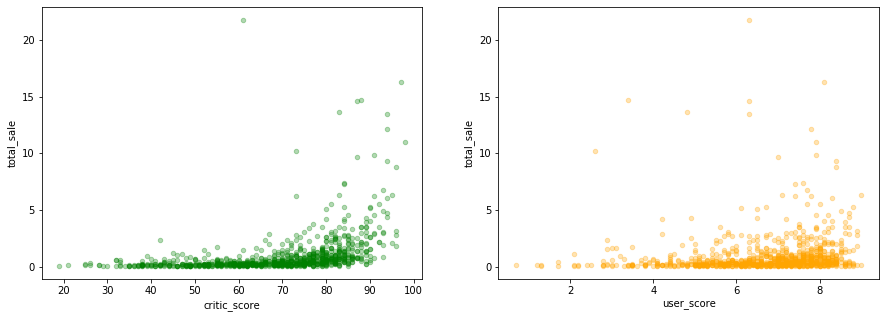

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
def createscatterplot(data, x1, x2, y, axes):
    data.plot(kind='scatter', x=x1, y=y, color='green', alpha=0.3, ax=ax[0]) 
    data.plot(kind='scatter', x=x2, y=y, color='orange', alpha=0.3, ax=ax[1]) 

createscatterplot(x360, 'critic_score', 'user_score', 'total_sale', ax)

Investigate the correlation between expert review and sale value by corr test

In [47]:
x360['total_sale'].corr(x360['critic_score'])

0.3931497242823624

Investigate the correlation between user review and sale value by corr test

In [48]:
x360['total_sale'].corr(x360['user_score'])

0.11381349200527151

**Question:** How did user and professional reviews affect sales for one popular platform? <br>
**Answer:**
- There are relatively weak positive correlations between user and professional reviews with total sales.
- Professional reviews seem to have stronger effect on total sale than user reviews. 

### 3.7 Compare the sales of the same games on other platforms

Look at which game are played in X360

In [49]:
game = x360['name'].unique()

Extract these games for other platforms (all platforms except for X360)

In [50]:
game_not_x360 = games_2005_2016.query('platform != "X360"', 
                                      engine='python').query('name in @game')

game_not_x360.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458 entries, 16 to 16709
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    2458 non-null   object 
 1   platform                2458 non-null   object 
 2   year_of_release         2458 non-null   Int64  
 3   genre                   2458 non-null   object 
 4   na_sales                2458 non-null   float64
 5   eu_sales                2458 non-null   float64
 6   jp_sales                2458 non-null   float64
 7   other_sales             2458 non-null   float64
 8   critic_score            1666 non-null   float64
 9   user_score              1761 non-null   float64
 10  rating                  2114 non-null   object 
 11  year_extract_from_name  197 non-null    Int64  
 12  total_sale              2458 non-null   float64
dtypes: Int64(2), float64(7), object(4)
memory usage: 273.6+ KB


Check if there is any game in the game_not_x360 not in the game list of x360 data

In [51]:
list(set(game_not_x360['name'].unique()) - set(game)) #Done

[]

Create a scatterplox to see the relationship between expert/user review and total sales in the same game but in other platforms

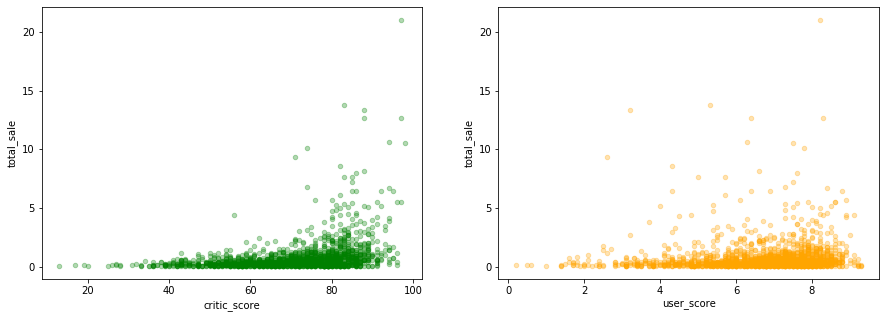

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

createscatterplot(game_not_x360, 'critic_score', 'user_score', 
                  'total_sale', ax)

Investigate the correlation between expert review and sale value by corr test

In [53]:
game_not_x360['total_sale'].corr(game_not_x360['critic_score'])

0.3358908730929404

Investigate the correlation between user review and sale value by corr test

In [54]:
game_not_x360['total_sale'].corr(game_not_x360['user_score'])

0.08162146315325836

**Question:** Compare the sales of the same games on X360 and other platforms, how did user and professional reviews affect sales for one popular platform? <br>
**Answer:** The relationship between user and professional reviews with total sales is similar between X360 and other platforms
- There are relatively weak positive correlations between user and professional reviews with total sales.
- Professional reviews seem to have stronger effect on total sale than user reviews. 

### 3.8 Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [55]:
game_by_genre = games_2005_2016.groupby('genre')['total_sale']\
    .agg(['sum', 'mean','var','std']).reset_index()

game_by_genre.sort_values(by='sum', ascending=False)

,genre,sum,mean,var,std
0,Action,1202.39,0.466948,1.092189,1.045078
10,Sports,854.17,0.615840,7.028507,2.651133
8,Shooter,758.56,0.910636,3.717753,1.928148
3,Misc,615.83,0.450168,2.029068,1.424454
7,Role-Playing,550.78,0.516195,1.696331,1.302433
6,Racing,355.12,0.554875,3.632989,1.906040
4,Platform,303.06,0.716454,5.339558,2.310748
9,Simulation,269.62,0.418665,1.703807,1.305300
2,Fighting,211.07,0.461860,0.847499,0.920597
1,Adventure,149.81,0.140667,0.124912,0.353430


Get the list of genre name in descending order of total sale

In [56]:
genre = game_by_genre.sort_values(by='sum', ascending=False)['genre'].tolist()
genre

['Action',
 'Sports',
 'Shooter',
 'Misc',
 'Role-Playing',
 'Racing',
 'Platform',
 'Simulation',
 'Fighting',
 'Adventure',
 'Puzzle',
 'Strategy']

Create the density plot of total sales by all genres

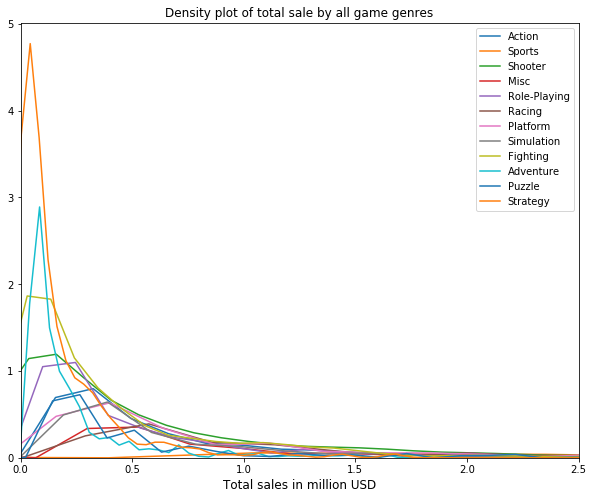

In [57]:
# instanciate the figure
fig = plt.figure(figsize = (10, 8))

# ----------------------------------------------------------------------------------------------------
# plot the data
# the idea is to iterate over each class
# extract their data ad plot a sepate density plot
# with their histogram
for class_ in genre:
    # extract the data
    x = games_2005_2016[games_2005_2016["genre"] == class_]["total_sale"]
    # plot the data using seaborn
    sns.distplot(x, hist=False, kde = True, label = "{}".format(class_))

plt.xlim(0,2.5)
plt.xlabel('Total sales in million USD', fontsize=12)  

    
# set the title of the plot
plt.title("Density plot of total sale by all game genres")

plt.legend()

Create the density plot for the top 3 and bottom 3 genres

In [58]:
#Get top 3 genre name
top_3_genre = game_by_genre.nlargest(3, ['sum'])['genre'].tolist()
top_3_genre

['Action', 'Sports', 'Shooter']

In [59]:
#Get bottom 3 genre name
bot_3_genre = game_by_genre.nsmallest(3, ['sum'])['genre'].tolist()
bot_3_genre

['Strategy', 'Puzzle', 'Adventure']

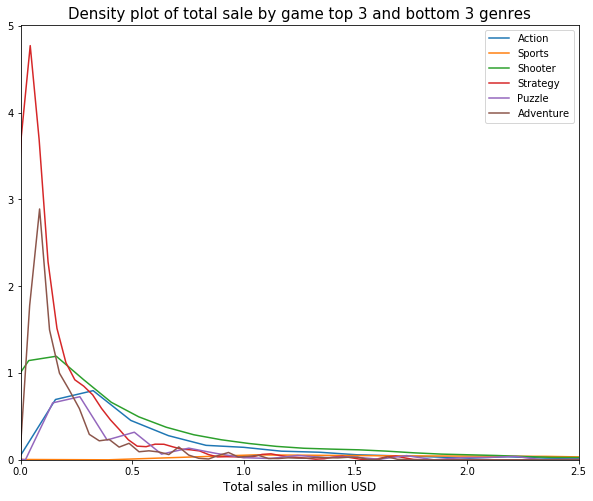

In [60]:
# instanciate the figure
fig = plt.figure(figsize = (10, 8))

# ----------------------------------------------------------------------------------------------------
# plot the data
# the idea is to iterate over each class
# extract their data ad plot a sepate density plot
# with their histogram
for class_ in (top_3_genre + bot_3_genre):
    # extract the data
    x = games_2005_2016[games_2005_2016["genre"] == class_]["total_sale"]
    # plot the data using seaborn
    sns.distplot(x, hist=False, kde = True, label = "{}".format(class_))

plt.xlim(0,2.5)
plt.xlabel('Total sales in million USD', fontsize=12)  


    
# set the title of the plot
plt.title("Density plot of total sale by game top 3 and bottom 3 genres", fontsize=15)

plt.legend()

**Comments:** 
- Most of genres' total sales lie in the range 0.05 to 0.5 million USD
- The top 3 genres have wider distribution of total sales compared to the bottom 3. They are also much more right-skewed, i.e. there are much more outliers (game) that have extremely high total sale, which skews the distribution to the right.

Get the data from top 3 and bottom 3 genres to investigate other characteristics

In [61]:
top_3 = games_2005_2016.query('genre in @top_3_genre', engine='python')
bot_3 = games_2005_2016.query('genre in @bot_3_genre', engine='python')

Compare top 3 and bottom 3

In [62]:
top_3.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,year_extract_from_name,total_sale
count,4795.000000,4795.000000,4795.000000,4795.000000,4795.000000,2848.000000,2896.000000,321.000000,4795.000000
mean,2009.986027,0.294853,0.184953,0.037921,0.069368,68.539677,6.822065,2010.984424,0.587095
std,3.248377,0.911634,0.669062,0.154671,0.225471,14.288113,1.489447,3.171613,1.813791
min,2005.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.200000,2000.000000,0.000000
25%,2007.000000,0.010000,0.000000,0.000000,0.000000,59.000000,6.000000,2009.000000,0.070000
50%,2010.000000,0.100000,0.030000,0.000000,0.010000,71.000000,7.100000,2011.000000,0.190000
75%,2012.000000,0.280000,0.150000,0.020000,0.060000,80.000000,7.900000,2014.000000,0.530000
max,2016.000000,41.360000,28.960000,3.960000,8.450000,98.000000,9.500000,2017.000000,82.540000


In [63]:
bot_3.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,year_extract_from_name,total_sale
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.00000,619.00000,547.000000,8.000000,1886.000000
mean,2009.540827,0.077699,0.052572,0.033945,0.01527,67.61874,6.988483,2008.500000,0.179486
std,2.837075,0.210244,0.204993,0.148531,0.05331,13.32856,1.682923,4.105745,0.528147
min,2005.000000,0.000000,0.000000,0.000000,0.00000,17.00000,0.000000,2000.000000,0.010000
25%,2007.000000,0.000000,0.000000,0.000000,0.00000,60.00000,6.300000,2007.000000,0.020000
50%,2009.000000,0.000000,0.000000,0.000000,0.00000,69.00000,7.400000,2009.000000,0.050000
75%,2011.000000,0.080000,0.030000,0.030000,0.01000,77.50000,8.100000,2011.250000,0.150000
max,2016.000000,3.430000,5.350000,5.320000,1.18000,94.00000,9.300000,2013.000000,15.280000


**Comments:**
- The year of game released among the top 3 seems to be slightly later than the bottom 3 genres.
- There are no significant difference in:
    - The ratio among sales in North America, European Union, Japan and other countries
    - Expert and user review score

In [64]:
top_3['rating'].value_counts()

E       1075
M        940
T        835
E10+     626
AO         1
EC         1
Name: rating, dtype: int64

In [65]:
bot_3['rating'].value_counts()

E       397
T       193
E10+    183
M        96
EC        2
RP        1
Name: rating, dtype: int64

**Comments:**
- The "Everyone" rating category represents the biggest part in both top 3 and bottom 3 genres
- The "Mature" (age 17+) rating category accounts for nearly 30% of the top 3 genres while it only accounts for around 11% of the bottom 3 genres.

In [66]:
top_3['platform'].value_counts()

PS3     739
X360    727
Wii     545
DS      517
PS2     418
PSP     383
PC      322
PS4     231
3DS     218
PSV     177
XOne    161
XB      151
WiiU     82
GC       68
GBA      55
DC        1
Name: platform, dtype: int64

In [67]:
bot_3['platform'].value_counts()

DS      540
PSP     310
PC      221
PS2     189
Wii     161
PSV     103
PS3      96
X360     81
3DS      72
PS4      35
GBA      21
XOne     17
XB       17
GC       12
WiiU     10
DC        1
Name: platform, dtype: int64

**Comments:**
- PS3, X360 and Wii are the top 3 platforms that are used most among top 3 genres while DS, PSP and PC are the top 3 platforms among the bottom 3 genres.

## Conclusion of Step 3:
- Not every period is significant in terms of the number of games released. There is a dramatic increase in the number of video games released in early 2000 till 2011, after that there is a significant drop. 2008-2009 is the peak period with the highest number of video games released, 1428-1426 games respectively. Before 1994, there are less than 100 games released each year. After 2011, less than 700 games were released each year.
- It generally takes around 4-6 years for a new platforms to appear, i.e. reach its peak in sale, and it takes around 5-7 years for an old platform to fade, i.e. reach its lowest in sale (approximately zero sales).
- The data of the period from 2005 - 2016 was selected because this period is highly likely to depict a new cycle of appearing and fading of game platforms
- In the period from 2005 - 2016, X360, PS3 and Wii are the top 3 platforms leading in sales. The following platforms are shrinking: PS2, Wii, DS, X360, PS3, PSP. The other platforms that ended their life earlier (before 2008) are: XB, GBA, GC, and DC. Though there is a tendency for decreasing, the following platforms have not reached the "appearing" period (4-6 years), so there is a chance for these platforms to rise, or at least last for several more years: PS4, XOne, 3DS, PSV, WiiU.
- There are significant differences in total sales among platforms due to the extreme sale values. Regarding the average sales (the median value), the difference is less significant, most of the platforms have the avarage sales below 300,000 USD.
- There are relatively weak positive correlations between user and professional reviews with total sales. Professional reviews seem to have stronger effect on total sale than user reviews.
- The relationship between user and professional reviews with total sales is similar between X360 and other platforms.
- The top 3 profitable genres have wider distribution of total sales compared to the bottom 3. They are also much more right-skewed. The "Everyone" rating category represents the biggest part in both top 3 and bottom 3 genres. The "Mature" (age 17+) rating category accounts for nearly 30% of the top 3 genres while it only accounts for around 11% of the bottom 3 genres. PS3, X360 and Wii are the top 3 platforms that are used most among top 3 genres while DS, PSP and PC are the top 3 platforms among the bottom 3 genres.

## Step 4: Create a user profile for each region

### Task description:
For each region (NA, EU, JP), determine:
- The top five platforms. Describe variations in their market shares from region to region.
- The top five genres. Explain the difference.
- Do ESRB ratings affect sales in individual regions?


Extract data for each region:
- North America (NA)
- European Union (EU)
- Japan (JP)

In [68]:
#Create list of required columns for each dataset
col = games_2005_2016.columns
NA_col = col.drop(labels=['eu_sales', 'jp_sales', 'other_sales', 
                          'year_extract_from_name','total_sale'])
EU_col = col.drop(labels=['na_sales', 'jp_sales', 'other_sales', 
                          'year_extract_from_name','total_sale'])
JP_col = col.drop(labels=['eu_sales', 'na_sales', 'other_sales', 
                          'year_extract_from_name','total_sale'])

In [69]:
#NA
NA = games_2005_2016[NA_col]
NA.head()

,name,platform,year_of_release,genre,na_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,76.0,8.0,E
2,Mario Kart Wii,Wii,2008,Racing,15.68,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,80.0,8.0,E
6,New Super Mario Bros.,DS,2006,Platform,11.28,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,58.0,6.6,E


In [70]:
#EU
EU = games_2005_2016[EU_col]
EU.head()

,name,platform,year_of_release,genre,eu_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,28.96,76.0,8.0,E
2,Mario Kart Wii,Wii,2008,Racing,12.76,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,10.93,80.0,8.0,E
6,New Super Mario Bros.,DS,2006,Platform,9.14,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,9.18,58.0,6.6,E


In [71]:
#JP
JP = games_2005_2016[JP_col]
JP.head()

,name,platform,year_of_release,genre,jp_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,3.77,76.0,8.0,E
2,Mario Kart Wii,Wii,2008,Racing,3.79,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,3.28,80.0,8.0,E
6,New Super Mario Bros.,DS,2006,Platform,6.50,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,2.93,58.0,6.6,E


### The top 5 platforms

In [72]:
#North America
top5_pf_na = NA.groupby('platform')['na_sales'].sum().reset_index()\
    .nlargest(5, ['na_sales'])['platform'].tolist()
top5_pf_na

['X360', 'Wii', 'PS3', 'DS', 'PS2']

In [73]:
#European Union
top5_pf_eu =EU.groupby('platform')['eu_sales'].sum().reset_index()\
    .nlargest(5, ['eu_sales'])['platform'].tolist()
top5_pf_eu

['PS3', 'X360', 'Wii', 'DS', 'PS4']

In [74]:
#Japan
top5_pf_jp = JP.groupby('platform')['jp_sales'].sum().reset_index()\
    .nlargest(5, ['jp_sales'])['platform'].tolist()
top5_pf_jp

['DS', '3DS', 'PS3', 'PSP', 'Wii']

Get the datasets for top 5 platforms in each region

In [75]:
top5_pf_na_df = NA.query('platform in @top5_pf_na', engine='python')
top5_pf_eu_df = EU.query('platform in @top5_pf_eu', engine='python')
top5_pf_jp_df = JP.query('platform in @top5_pf_jp', engine='python')

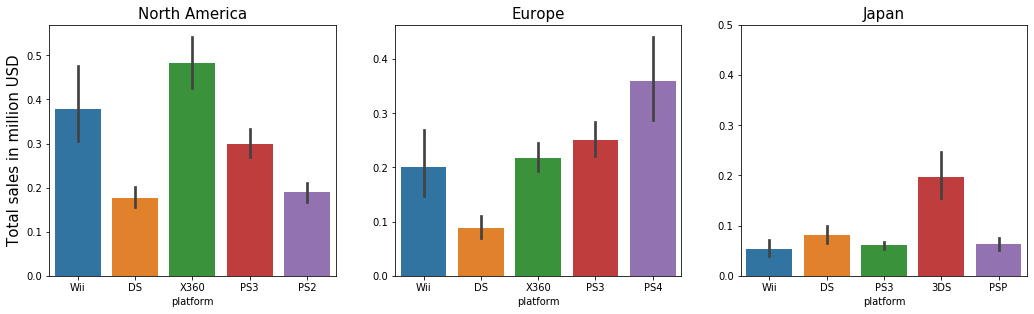

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def createbarplot(df1, df2, df3, x, y1, y2, y3, title1, title2, title3, axes):
    sns.barplot(ax=axes[0], x=x, y=y1, data=df1)
    sns.barplot(ax=axes[1], x=x, y=y2, data=df2)
    sns.barplot(ax=axes[2], x=x, y=y3, data=df3)
    axes[0].set_title(title1, fontsize=15)
    axes[1].set_title(title2, fontsize=15)
    axes[2].set_title(title3, fontsize=15)
    axes[0].set_ylabel('Total sales in million USD',size=15)
    axes[1].set_ylabel(None)
    axes[2].set_ylabel(None)
    fig.tight_layout(pad=3.0)
    plt.ylim(0,0.5)

createbarplot(top5_pf_na_df, top5_pf_eu_df, top5_pf_jp_df, 'platform',
              'na_sales', 'eu_sales', 'jp_sales', 
              'North America', 'Europe', 'Japan', axes)



**Comments:**
- North America an Europe seem to have higher total sales from the top 5 platforms compared with Japan.
- Wii, DS and PS3 are among the top 5 flatforms in all 3 regions. However the share of these platforms together with other platforms are different among the 3 regions.
- X360 ranks first in North America, while PS4 is the biggest share in Europe, and 3DS takes the lead, also far beyond the remaining platforms, in Japan.
- While Wii plays an important role (rank second) in North America, it ranks fourth and fifth in Europe and Japan respectively.

### The top 5 genres

In [77]:
#North America
top5_gen_na = NA.groupby('genre')['na_sales'].sum().reset_index()\
    .nlargest(5, ['na_sales'])['genre'].tolist()
top5_gen_na

['Action', 'Sports', 'Shooter', 'Misc', 'Role-Playing']

In [78]:
#European Union
top5_gen_eu= EU.groupby('genre')['eu_sales'].sum().reset_index()\
    .nlargest(5, ['eu_sales'])['genre'].tolist()
top5_gen_eu

['Action', 'Sports', 'Shooter', 'Misc', 'Racing']

In [79]:
#Japan
top5_gen_jp = JP.groupby('genre')['jp_sales'].sum().reset_index()\
    .nlargest(5, ['jp_sales'])['genre'].tolist()
top5_gen_jp

['Role-Playing', 'Action', 'Misc', 'Sports', 'Platform']

Get the datasets for top 5 platforms in each region

In [80]:
top5_gen_na_df = NA.query('genre in @top5_gen_na', engine='python')
top5_gen_eu_df = EU.query('genre in @top5_gen_eu', engine='python')
top5_gen_jp_df = JP.query('genre in @top5_gen_jp', engine='python')

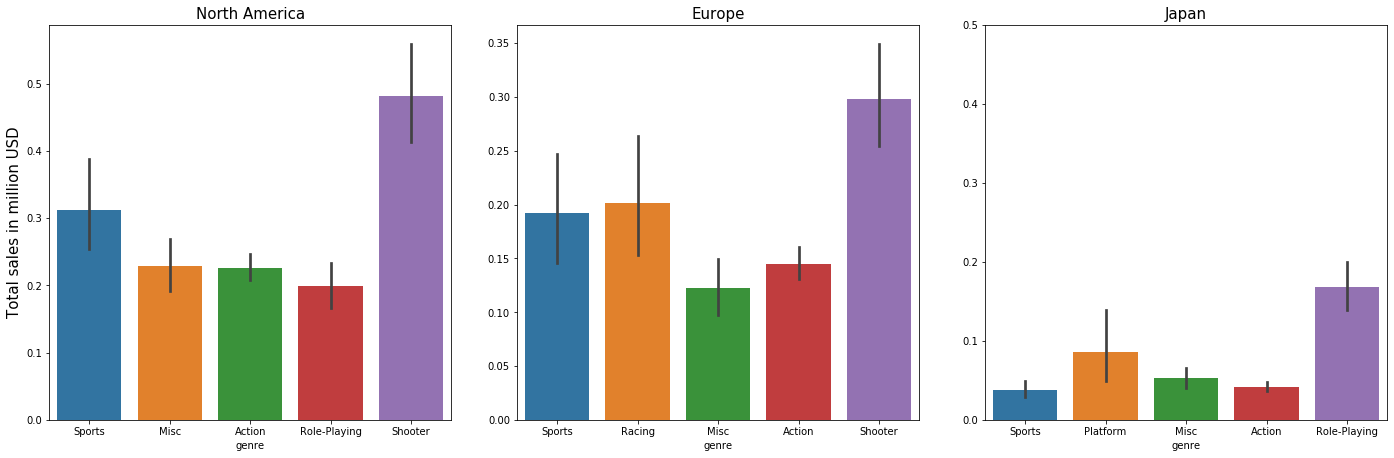

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))


createbarplot(top5_gen_na_df, top5_gen_eu_df, top5_gen_jp_df,'genre',
              'na_sales', 'eu_sales', 'jp_sales', 
              'North America', 'Europe', 'Japan', axes)



**Comments:**
- North America an Europe seem to have higher total sales from the top 5 genres compared with Japan.
- Sports, Misc, and Action are among the top 5 genres in all 3 regions. However the share of these platforms together with other platforms are different among the 3 regions.
- Shooter ranks first in North America and Europe, while Role-Playing is the biggest share in Japan.
- While Sports plays an important role (rank second) in North America, it ranks last in Japan.

### Do ESRB ratings affect sales in individual regions?

In [82]:
#Investigate the data
games_2005_2016['rating'].value_counts()

E       2673
T       2013
E10+    1380
M       1236
EC         8
RP         1
AO         1
Name: rating, dtype: int64

EC, RP and AO have less than 10 games each for rating, I'll drop the games that have these ratings to reduce the number of rating categories 

In [83]:
rate_drop = ['EC', 'RP', 'AO']
games_2005_2016_clean = games_2005_2016.query('rating not in @rate_drop')
games_2005_2016_clean['rating'].value_counts() #Done removing

NA_clean = NA.query('rating not in @rate_drop')
EU_clean = EU.query('rating not in @rate_drop')
JP_clean = JP.query('rating not in @rate_drop')

NA_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11270 entries, 0 to 16714
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             11270 non-null  object 
 1   platform         11270 non-null  object 
 2   year_of_release  11270 non-null  Int64  
 3   genre            11270 non-null  object 
 4   na_sales         11270 non-null  float64
 5   critic_score     5646 non-null   float64
 6   user_score       5537 non-null   float64
 7   rating           7302 non-null   object 
dtypes: Int64(1), float64(3), object(4)
memory usage: 803.4+ KB


To answer the research question, ***"Do ESRB ratings affect sales in individual regions?"***, I formulate the following hypotheses:
- Null hypothesis (H0): There is no difference in the mean sales among ESRB rating categories in individual regions
- Alternative hypothesis (H1): There is difference in the mean sales among ESRB rating categories in individual regions

I will conduct hypothesis testing for each region. <br>

Hypothesis test selection: Because we need to test the sales (continuous variable) among more than two rating categories (categorical variable), we should use One way ANOVA test or its non-parametric equivalent test, Kruskal–Wallis test by ranks. Will check the normality of the distribution of sales first to choose either ANOVA (if normal) or Kruskal–Wallis test by ranks (if not normal).

Test the normality of distribution

### North America

In [84]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E"')['na_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


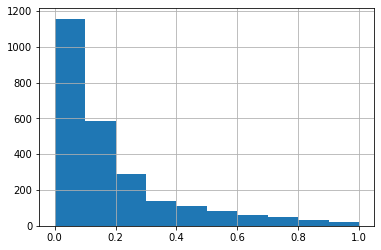

In [85]:
games_2005_2016_clean.query('rating == "E"')['na_sales'].hist(range=(0,1))

In [86]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "T"')['na_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


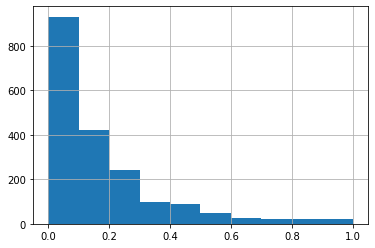

In [87]:
games_2005_2016_clean.query('rating == "T"')['na_sales'].hist(range=(0,1))

In [88]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E10+"')['na_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


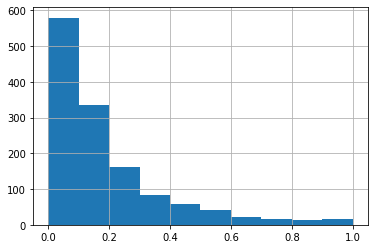

In [89]:
games_2005_2016_clean.query('rating == "E10+"')['na_sales'].hist(range=(0,1))

In [90]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "M"')['na_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


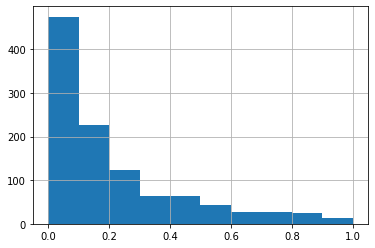

In [91]:
games_2005_2016_clean.query('rating == "M"')['na_sales'].hist(range=(0,1))

All right skewed, therefore we need to use the non-parametric test of one way ANOVA, which is Kruskal–Wallis test by ranks.

### Europe

In [92]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E"')['eu_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


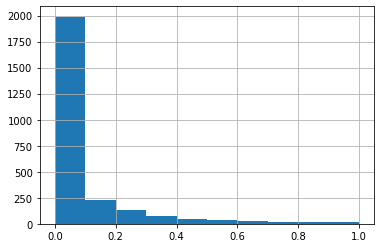

In [93]:
games_2005_2016_clean.query('rating == "E"')['eu_sales'].hist(range=(0,1))

In [94]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "T"')['eu_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


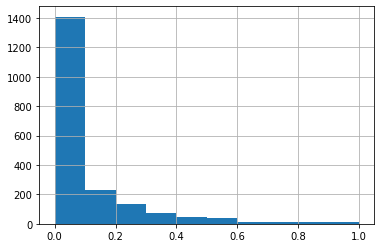

In [95]:
games_2005_2016_clean.query('rating == "T"')['eu_sales'].hist(range=(0,1))

In [96]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E10+"')['eu_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


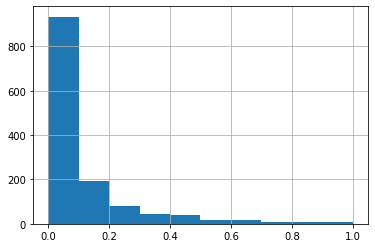

In [97]:
games_2005_2016_clean.query('rating == "E10+"')['eu_sales'].hist(range=(0,1))

In [98]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "M"')['eu_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


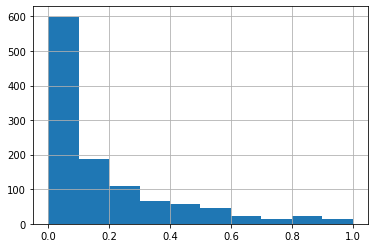

In [99]:
games_2005_2016_clean.query('rating == "M"')['eu_sales'].hist(range=(0,1))

All right skewed, therefore we need to use the non-parametric test of one way ANOVA, which is Kruskal–Wallis test by ranks.

### Japan

In [100]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E"')['jp_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


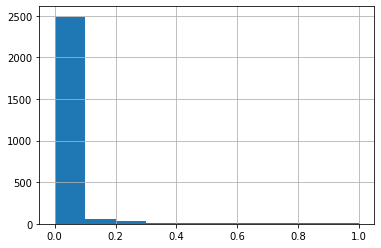

In [101]:
games_2005_2016_clean.query('rating == "E"')['jp_sales'].hist(range=(0,1))

In [102]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "T"')['jp_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


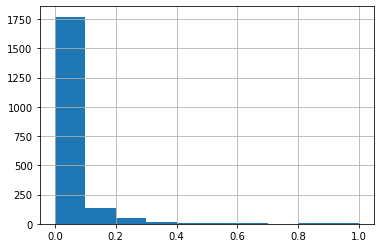

In [103]:
games_2005_2016_clean.query('rating == "T"')['jp_sales'].hist(range=(0,1))

In [104]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "E10+"')['jp_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


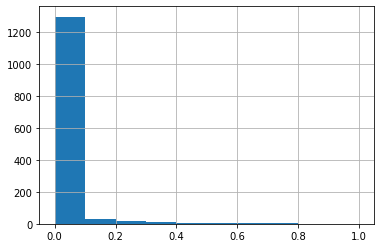

In [105]:
games_2005_2016_clean.query('rating == "E10+"')['jp_sales'].hist(range=(0,1))

In [106]:
k2, p = stats.normaltest(games_2005_2016_clean\
                         .query('rating == "M"')['jp_sales'])
alpha = 0.05
print('p=%.4f' % (p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p=0.0000
The variable does not from a normal distribution


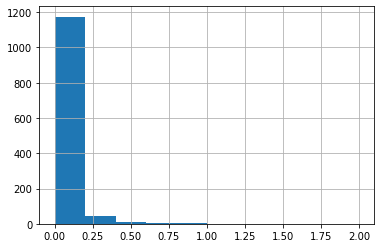

In [107]:
games_2005_2016_clean.query('rating == "M"')['jp_sales'].hist(range=(0,2))

All right skewed, therefore we need to use the non-parametric test of one way ANOVA, which is Kruskal–Wallis test by ranks.

Create subdatasets for each category in each region

In [108]:
#North America
NA_E = NA_clean.query('rating == "E"')
NA_T = NA_clean.query('rating == "T"')
NA_E10 = NA_clean.query('rating == "E10+"')
NA_M = NA_clean.query('rating == "M"')

#Europe
EU_E = EU_clean.query('rating == "E"')
EU_T = EU_clean.query('rating == "T"')
EU_E10 = EU_clean.query('rating == "E10+"')
EU_M = EU_clean.query('rating == "M"')

#Japan
JP_E = JP_clean.query('rating == "E"')
JP_T = JP_clean.query('rating == "T"')
JP_E10 = JP_clean.query('rating == "E10+"')
JP_M = JP_clean.query('rating == "M"')


### Test the hypothesis in North America

In [109]:
# compare samples
stat, p = stats.kruskal(NA_E['na_sales'], NA_T['na_sales'], 
                        NA_E10['na_sales'], NA_M['na_sales'], nan_policy='omit')

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('There is difference in the mean sales among ESRB rating categories',
          'in North America (reject H0 at an alpha of 0.05)')

Statistics=51.458, p=0.000
There is difference in the mean sales among ESRB rating categories in North America (reject H0 at an alpha of 0.05)


### Test the hypothesis in Europe

In [110]:
# compare samples
stat, p = stats.kruskal(EU_E['eu_sales'], EU_T['eu_sales'], 
                        EU_E10['eu_sales'], EU_M['eu_sales'], nan_policy='omit')

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('There is difference in the mean sales among ESRB rating categories',
          'in Europe (reject H0 at an alpha of 0.05)')


Statistics=480.252, p=0.000
There is difference in the mean sales among ESRB rating categories in Europe (reject H0 at an alpha of 0.05)


### Test the hypothesis in Japan

In [111]:
# compare samples
stat, p = stats.kruskal(JP_E['jp_sales'], JP_T['jp_sales'], 
                        JP_E10['jp_sales'], JP_M['jp_sales'], nan_policy='omit')

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('There is difference in the mean sales among ESRB rating categories',
          'in Japan (reject H0 at an alpha of 0.05)')
    

Statistics=383.133, p=0.000
There is difference in the mean sales among ESRB rating categories in Japan (reject H0 at an alpha of 0.05)


### Create bargraphs depicting the relationship between rating and sale in 3 regions

Prepare the data

In [112]:
games_2005_2016_clean.head()

rating = games_2005_2016_clean[['name', 'na_sales', 'eu_sales', 'jp_sales', 
                                'rating', 'platform', 'genre','user_score','total_sale']]
rating_grouped = rating.groupby('rating').agg({'na_sales':['sum'],
                                              'eu_sales':['sum'],
                                              'jp_sales':['sum']}).reset_index()


rating_grouped.columns = ['rating', 'North_America', 'Europe', 'Japan']

rating_grouped

rating_grouped = rating_grouped.reset_index()
rating_grouped_long = pd.melt(rating_grouped, id_vars='rating', 
        value_vars=['North_America', 'Europe', 'Japan'])

rating_grouped_long.columns = ['rating', 'region', 'sale_value']

Create barplot for 3 regions

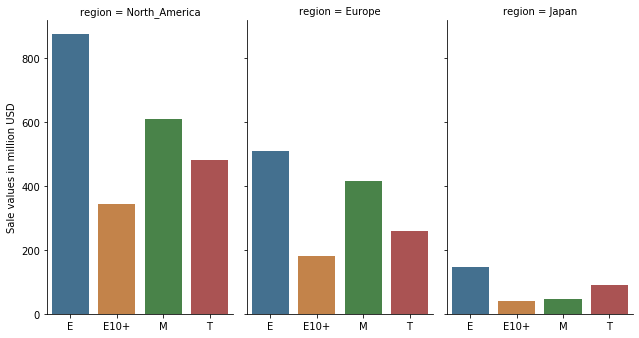

In [113]:
g = sns.catplot(x='rating', y='sale_value', col="region",
                data=rating_grouped_long, saturation=.5,
                kind="bar", ci=None, aspect=.6)

(g.set_axis_labels("", "Sale values in million USD"))


## Conclusions of Step 4:
### North America
- The top five platforms in descending order of sales: X360, Wii, PS3, PS2 and DS.
- The top five genres in descending order of sales: Shooter, Sports, Misc, Action and Role-Playing. 
- ESRB ratings affect sales in North America. It seems that 'everyone' category are the most favorite one, and therefore the most profitable in all 3 regions. 'Mature' category ranks second. 

### Europe
- The top five platforms in descending order of sales: PS4, PS3, X360, Wii and DS.
- The top five genres in descending order of sales: Shooter, , Racing, Sports, Action and Misc. 
- ESRB ratings affect sales in Europe. 'Everyone' category ranks first, followed by 'Mature'.

### Japan
- The top five platforms in descending order of sales: 3DS, DS, PSP, PS3 and Wii.
- The top five genres in descending order of sales: Role-Playing, Platform, Misc, Action and Sports. 
- ESRB ratings affect sales in Japan. 'Everyone' also ranks first, followed by 'Teen'.

## Step 5: Test the following hypotheses

### Task description:
Test the following hypotheses:
- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

Set the alpha threshold value yourself. <br>
Explain:
- How you formulated the null and alternative hypotheses
- What significance level you chose to test the hypotheses, and why


### 5.1 Hypothesis 1: Average user ratings of the Xbox One and PC platforms are the same

#### Prepare the data

In [114]:
rating['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'PSP', 'XOne',
       'WiiU', 'PS2', 'GBA', 'PSV', 'XB', 'GC', 'DC'], dtype=object)

In [115]:
xbox = rating.query('platform == "XOne"', engine='python')
pc = rating.query('platform == "PC"', engine='python')

#### Test normality of the distribution
Use 4 normality test: 2 visual tests and 2 statistical tests
#### 1. Visual normality test <br>
- Histogram plot: If the data is normally distributed the histogram plot shows the familiar bell shape. Otherwise, the data is not normally distributed
- Q-Q plot: If the data is normally distributed, the points in the QQ-normal plot lie closely on a straight diagonal line. There are a few small deviations, especially at the bottom of the plot, which is to be expected given the small data sample. Otherwise, the data is not normally distributed

#### 2. Statistical normality test <br>
- H0: the sample was drawn from a Gaussian distribution (normally distributed)
- Ha: the sample was not drawn from a Gaussian distribution (not normally distributed)
    - p <= alpha: reject H0, not normal.
    - p > alpha: fail to reject H0, normal.
- The two tests are:
    - D’Agostino’s K^2 Test
    - Shapiro-Wilk Test


#### Test normality of the distribution for "xbox" platform

#### Visual normality test

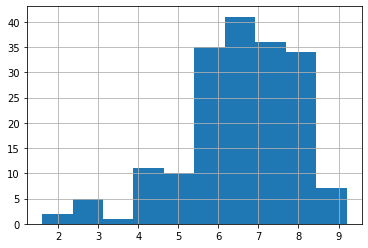

In [116]:
xbox['user_score'].hist()

Not look like a bell shape

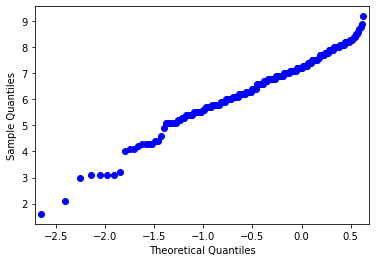

In [117]:
qqplot(xbox['user_score'], line='s')
plt.show()

The deviation from the straightline is significant

#### Statistical normality test

In [118]:
#D’Agostino’s K^2 Test
k2, p = stats.normaltest(xbox['user_score'], nan_policy='omit')
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p = 1.15349e-05
The variable does not from a normal distribution


In [119]:
#Shapiro-Wilk test
#Drop na values
xbox1 = xbox.dropna(subset=['user_score'])
# normality test
stat, p = shapiro(xbox1['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('The variable comes from a normal distribution')
else:
    print('The variable does not from a normal distribution')

Statistics=0.955, p=0.000
The variable does not from a normal distribution


#### Test normality of the distribution for "pc" platform

#### Visual normality test

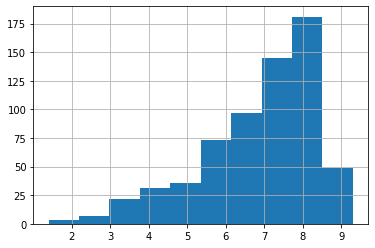

In [120]:
pc['user_score'].hist()

Approximate bell shape, but the left skew is a bit long

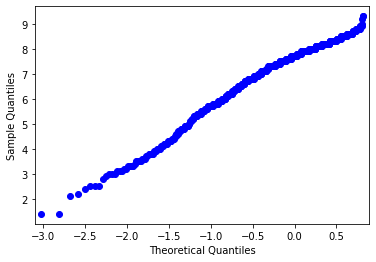

In [121]:
qqplot(pc['user_score'], line='s')
plt.show()

There are some noticeable deviating points from the straight line.

#### Statistical normality test

In [122]:
#D’Agostino’s K^2 Test
k2, p = stats.normaltest(pc['user_score'], nan_policy='omit')
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p = 4.10322e-20
The variable does not from a normal distribution


In [123]:
#Shapiro-Wilk test
pc1 = pc.dropna(subset=['user_score'])
# normality test
stat, p = shapiro(pc1['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.914, p=0.000
Sample does not look Gaussian (reject H0)


#### Conclusion for normality check for hypothesis test 1: The data is not normally distributed.

### Hypothesis test selection

To test the statement, ***Average user ratings of the Xbox One and PC platforms are the same***, I formulate the following hypotheses:
- Null hypothesis (H0): Average user ratings of the Xbox One and PC platforms are the same.
- Alternative hypothesis (H1): Average user ratings of the Xbox One and PC platforms are not the same.

Hypothesis test selection: Because we need to test the average user rating score (continuous variable) between two platforms (categorical variable), and the data is not normal distributed, we should use **Mann-Whitney U Test (equivalent of t-test)**

alpha thresold = 0.05 was chosen because this is a frequently thresold chosen in other studies.

Conduct the Mann-Whitney U Test

In [124]:
stat, p = mannwhitneyu(xbox['user_score'], 
                       pc['user_score'])

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Average user ratings of the Xbox One and PC platforms are the same')
else:
    print('Average user ratings of the Xbox One and PC platforms are not the same')

stat=96290.000, p=0.179
Average user ratings of the Xbox One and PC platforms are the same


Quick bar graph to see the comparison in user rating between Xbox One and PC platforms

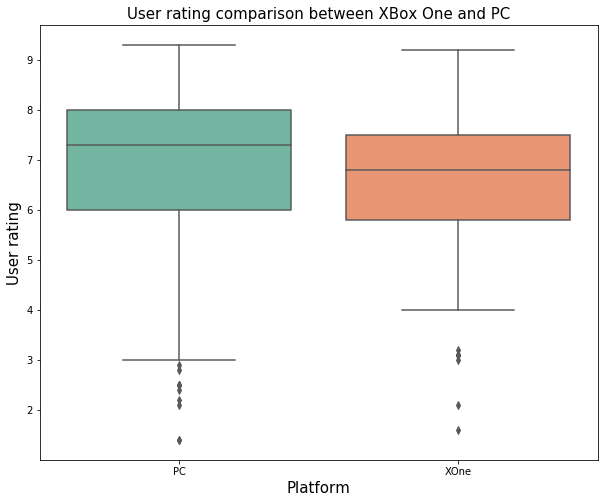

In [125]:
rating_xbox_pc = rating.query('platform == "XOne" or platform == "PC"',
                              engine='python')
def createboxplot(x, y, data, title, xlabel, ylabel):
    plt.figure(figsize=(10,8))
    sns.boxplot(x=x, y=y, data=data, palette="Set2")
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    
createboxplot('platform', 'user_score', 
              rating_xbox_pc, 'User rating comparison between XBox One and PC', 
              'Platform', 'User rating')

### 5.2 Hypothesis 2: Average user ratings for the Action and Sports genres are different

#### Prepare the data

In [126]:
rating['genre'].unique()

array(['Sports', 'Racing', 'Platform', 'Misc', 'Simulation', 'Action',
       'Role-Playing', 'Puzzle', 'Shooter', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [127]:
action = rating.query('genre == "Action"', engine='python')
sport = rating.query('genre == "Sports"', engine='python')

#### Test normality of the distribution for "action" genre

#### Visual normality test

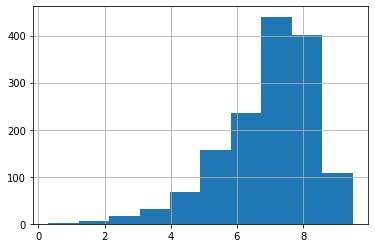

In [128]:
action['user_score'].hist()

Approximate bell shape

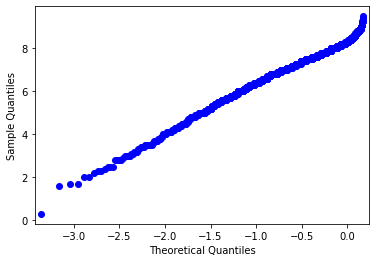

In [129]:
qqplot(action['user_score'], line='s')
plt.show()

The deviation from the straight line is not significant

#### Statistical normality test

In [130]:
#D’Agostino’s K^2 Test
k2, p = stats.normaltest(action['user_score'], nan_policy='omit')
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p = 1.01439e-51
The variable does not from a normal distribution


In [131]:
#Shapiro-Wilk test
action1 = action.dropna(subset=['user_score'])
# normality test
stat, p = shapiro(action1['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.933, p=0.000
Sample does not look Gaussian (reject H0)


#### Test normality of the distribution for "sport" genre

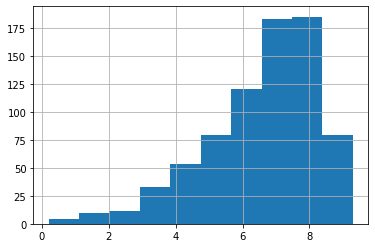

In [132]:
sport['user_score'].hist()

Approximate bell shape

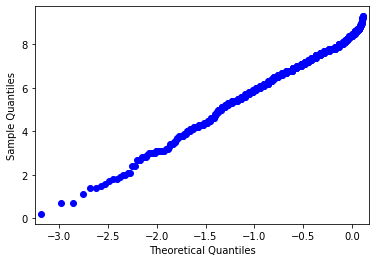

In [133]:
qqplot(sport['user_score'], line='s')
plt.show()

The deviation from the straight line is not significant

In [134]:
#D’Agostino’s K^2 Test
k2, p = stats.normaltest(sport['user_score'], nan_policy='omit')
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The variable does not from a normal distribution")
else:
    print("The variable comes from a normal distribution")

p = 7.22709e-23
The variable does not from a normal distribution


In [135]:
#Shapiro-Wilk test
sport1 = sport.dropna(subset=['user_score'])
# normality test
stat, p = shapiro(sport1['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.935, p=0.000
Sample does not look Gaussian (reject H0)


#### Conclusion for normality check for hypothesis test 2: Though the visual normality tests show the data is approximately normally distributed, the statistical tests do not prove so. Therefore, the data is not normally distributed.

### Hypothesis test selection

To test the statement, ***Average user ratings for the Action and Sports genres are different***, I formulate the following hypotheses:
- Null hypothesis (H0): Average user ratings for the Action and Sports genres are the same.
- Alternative hypothesis (H1): Average user ratings for the Action and Sports genres are different.

Hypothesis test selection: Because we need to test the average user rating score (continuous variable) between two genres (categorical variable), and the data is not normal distributed, we should use **Mann-Whitney U Test (equivalent of t-test)**.

alpha thresold = 0.05 was selected because this is frequently chosen in previous experiments.


Conduct the Mann-Whitney U Test

In [136]:
stat, p = mannwhitneyu(action['user_score'], 
                       sport['user_score'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Average user ratings of the Action and Sports genres are the same')
else:
    print('Average user ratings of the Action and Sports genres are not the same')

stat=1428011.000, p=0.000
Average user ratings of the Action and Sports genres are not the same


Quick bar graph to see the difference between Action and Sports genres

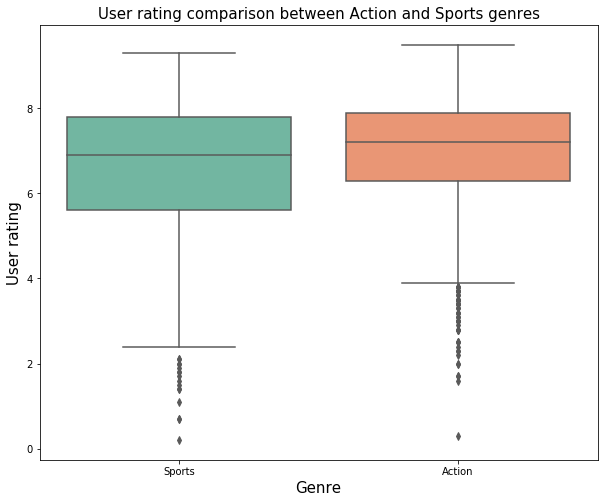

In [137]:
rating_action_sport = rating.query('genre == "Action" or genre == "Sports"', engine='python')
createboxplot('genre', 'user_score', 
              rating_action_sport, 'User rating comparison between Action and Sports genres', 
              'Genre', 'User rating')

## Conclusions for Step 5:

Because we need to test the average user rating score (continuous variable) between two platforms and then two genres (categorical variable), and the data are not normal distributed, we should use Mann-Whitney U Test (equivalent of t-test).

- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are not the same.<br>
***alpha threshold: 0.05***

## General Conclusions:
- The years between early 2000 and 2011 seem to be the golden age of video games in terms of number of games released and total sales.
- It generally takes around 4-6 years for a new platforms to reach its peak in sale, and it takes around 5-7 years for an old platform to fade, i.e. reach its lowest in sale (approximately zero sales).
- The data of the period from 2005 - 2016 was selected because this period is highly likely to depict a new cycle of appearing and fading of game platforms
- In this period, X360, PS3 and Wii are the top 3 platforms leading in sales. The following platforms are shrinking: PS2, Wii, DS, X360, PS3, PSP. The other platforms that ended their life earlier (before 2008) are: XB, GBA, GC, and DC. Though there is a tendency for decreasing, the following platforms have not reached their peak (because it usually takes 4-6 years to reach the peak), so there is a chance for these platforms to rise after 2016, or at least last for several more years: PS4, XOne, 3DS, PSV, WiiU.
- There are significant differences in total sales among platforms due to the extreme sale values. However the difference in the average sales (the median value) is less significant, most of the platforms have the avarage sales below 300,000 USD.
- There are relatively weak positive correlations between user and professional reviews with total sales. Professional reviews seem to have stronger effect on total sale than user reviews.
- Though there are a wide variety of choices, Wii, PS3 and PS are the most popular platforms across North America, Europe and Jpan. Sports, Action and Misc are the genres that are loved by gamers in all 3 regions. 
- It seems that the games under the "Everyone" category is the one generates the biggest share of revenue. It's true because these games do not have a restriction on age, i.e. the more people can and are not restricted to play them.
- Having said so, the games under the 'Mature' cateogry is the second revenue-generator in North America and Europe. 
- XBox One and PC platforms enjoy the same level of user review while Action and Sports genres differ in user reviews where Action games tend to have higher review from users.

---------End of Project---------